In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [4]:
raw = pd.read_csv('./data/secondary_data.csv', sep=';')

## Data preprocessing

In [5]:
# we count the number of missing values per column
nas = raw.isna().sum()
nas

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [6]:
# select columns with >40% of the rows missing
columns_missing = nas.loc[nas > 0.4*len(raw)]
columns_missing

gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
spore-print-color    54715
dtype: int64

In [7]:
# drop columns with high volume of missing rows
data = raw.drop(columns_missing.index, axis=1)
data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,f,e,w,16.95,17.09,w,t,g,d,w
1,p,16.60,x,g,o,f,e,w,17.99,18.19,w,t,g,d,u
2,p,14.07,x,g,o,f,e,w,17.80,17.74,w,t,g,d,w
3,p,14.17,f,h,e,f,e,w,15.77,15.98,w,t,p,d,w
4,p,14.64,x,h,o,f,e,w,16.53,17.20,w,t,p,d,w


### Data processing

In [8]:
# split into X and y
# for y: 'p' is poisonous, 'e' is edible
y = data['class'].apply(lambda x: x == 'p').astype(int)
X = data.drop(['class'], axis=1)
# has-ring is a boolean so we can process it directly
X['has-ring'] = X['has-ring'].apply(lambda x: x == 't').astype(int)

# select categorical and numerical columns
cat = X.select_dtypes('object').columns
num = ['cap-diameter', 'stem-height', 'stem-width']

#### Imputing missing data

In [9]:
# the remaining missing values
X[cat].isna().sum()

cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-color                  0
stem-color                  0
ring-type                2471
habitat                     0
season                      0
dtype: int64

In [10]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion

# to impute strings we do not have much choice
# especially given the high amount of missing values
# we will replace missings with the most frequent value of each column
# we will also add a 'missing indicator' to the dataframe,
# a sparse boolean matrix showing which features were missing beforehand
# this will allow our estimator to take missing values into consideration
imputer = FeatureUnion(
     transformer_list=[
         ('features', SimpleImputer(strategy='most_frequent')),
         ('indicators', MissingIndicator())
    ]
)

x_imp = imputer.fit_transform(X[cat])
# we can show a sample of how this would look
df_imp = pd.DataFrame(data=x_imp, columns=[*cat, *[f'missing_{i}' for i in range(x_imp.shape[1]-len(cat))]])
print('Count of missing values on categorical columns:')
print(df_imp[cat].isna().sum())
print('\nMissing indicators:')
print(df_imp.filter(regex='^missing_\d').sum())
df_imp.head()

Count of missing values on categorical columns:
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-color              0
ring-type               0
habitat                 0
season                  0
dtype: int64

Missing indicators:
missing_0    14120
missing_1     9884
missing_2     2471
dtype: object


,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-color,ring-type,habitat,season,missing_0,missing_1,missing_2
0,x,g,o,f,e,w,w,g,d,w,False,False,False
1,x,g,o,f,e,w,w,g,d,u,False,False,False
2,x,g,o,f,e,w,w,g,d,w,False,False,False
3,f,h,e,f,e,w,w,p,d,w,False,False,False
4,x,h,o,f,e,w,w,p,d,w,False,False,False


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# we make data pipelines for numerical & categorical variables
num_pipeline = Pipeline([
        # standardize numerical values
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        # impute missing values + add missing indicators
        ('imputer', imputer),
        # encode strings as ints
        ('ord_enc', OrdinalEncoder())
    ])

In [12]:
# apply the pipeline
full_pipeline = ColumnTransformer([
         ('num', num_pipeline, num),
         ('cat', cat_pipeline, cat),
     ])
X = full_pipeline.fit_transform(X)
df_processed = pd.DataFrame(data=X, columns=[*cat, *[f'missing_{i}' for i in range(X.shape[1]-len(cat))]])

### Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((40916, 16), (20153, 16))

## Gradient boosting

### XGBoost

In [57]:
from xgboost import XGBClassifier

bst = XGBClassifier(booster = 'dart', n_estimators=250, max_depth=7, learning_rate=0.1, rate_drop = 0.2, objective='binary:logistic')

In [58]:
bst.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [67]:
from sklearn.metrics import accuracy_score

preds = bst.predict(X_test)
f'Accuracy (test) for XGBoost {accuracy_score(preds, y_test)*100:.2f}'

#I tried implementing this but it didn't work, kept complaining 
#'Number of columns in data must equal to trained model' while preds and y_test have the same shape

#bst.score(preds, y_test)

'Accuracy (test) for XGBoost 93.92'

In [68]:
#importance of features in the XGBoost model, shows that no features are completely obsolete
print(bst.feature_importances_)

[0.04386839 0.08965469 0.07507179 0.05016253 0.083542   0.03364799
 0.11431355 0.06188498 0.06058193 0.07767479 0.10863064 0.04311561
 0.01465385 0.07542112 0.02475194 0.04302416]


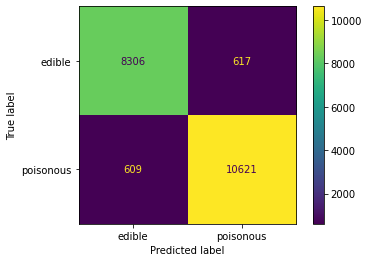

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#poisonous = 1, edible = 0

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = ['edible', 'poisonous'])

In [65]:
#possible leave this out since it only improves accuracy by 3 percentage points
from sklearn.model_selection import KFold
from tqdm import tqdm

skf = KFold(n_splits=5)
model = None
accs = np.zeros(skf.get_n_splits(X, y))

for i, (train, test) in tqdm(enumerate(skf.split(X, y))):
    model = bst.fit(X[train], y[train], xgb_model=model)
    preds = bst.predict(X[test])
    accs[i] = accuracy_score(y[test], preds)

0it [00:10, ?it/s]


KeyboardInterrupt: 

In [48]:
accs

array([0.53242181, 0.96798756, 0.99361389, 0.99697069, 0.99475968])

## Neural network

In [78]:
import tensorflow as tf
from tensorflow import keras

In [91]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               4352      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 334,337
Trainable params: 334,337
Non-tr

### Custom metrics

In [126]:
import keras.backend as K

def weighted_recall_spec(recall_weight, spec_weight):
    def recall_specificity(y_true, y_pred):
        TN = tf.logical_and(y_true == 0, y_pred == 0)
        TP = tf.logical_and(y_true == 1, y_pred == 1)

        FP = tf.logical_and(y_true == 0, y_pred == 1)
        FN = tf.logical_and(y_true == 1, y_pred == 0)

        TN = K.sum(K.cast(TN, K.floatx()))
        FP = K.sum(K.cast(FP, K.floatx()))
        TP = K.cast(TP, K.floatx())
        FN = K.cast(FN, K.floatx())

        specificity = TN / (TN + FP + K.epsilon())
        recall = TP / (TP + FN + K.epsilon())

        return 1.0 - (recall_weight*recall + spec_weight*specificity)

    return recall_specificity

In [127]:
recall_spec = weighted_recall_spec(recall_weight=0.7, spec_weight=0.3)

### Training

In [128]:
adam = keras.optimizers.Adam(learning_rate=1e-2)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[
                       keras.metrics.FalseNegatives(name='false_negatives'),
                       keras.metrics.FalsePositives(name='false_positives'),
                       keras.metrics.TrueNegatives(name='true_negatives'),
                       keras.metrics.TruePositives(name='true_positives'),
                       recall_spec]
             )

In [129]:
# reduce false_negatives
class_weight = {0: 0.3, 1: 0.7}


In [130]:
early_stop = keras.callbacks.EarlyStopping(monitor='false_negatives', patience=10)

In [125]:
history = model.fit(X_train, y_train,
                    validation_split=0.1, epochs=50, batch_size=32,
                    callbacks=[early_stop], class_weight=class_weight)

Epoch 1/50
1151/1151 [==============================] - 5s 4ms/step - loss: 0.1676 - false_negatives: 1082.0000 - false_positives: 6922.0000 - true_negatives: 9547.0000 - true_positives: 19273.0000 - wrap: 0.9912 - val_loss: 0.1455 - val_false_negatives: 63.0000 - val_false_positives: 168.0000 - val_true_negatives: 1621.0000 - val_true_positives: 2240.0000 - val_wrap: 0.9737
Epoch 2/50
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0595 - false_negatives: 514.0000 - false_positives: 1630.0000 - true_negatives: 14839.0000 - true_positives: 19841.0000 - wrap: 0.9458 - val_loss: 0.0844 - val_false_negatives: 15.0000 - val_false_positives: 117.0000 - val_true_negatives: 1672.0000 - val_true_positives: 2288.0000 - val_wrap: 0.9264
Epoch 3/50
 208/1151 [====>.........................] - ETA: 3s - loss: 0.0434 - false_negatives: 65.0000 - false_positives: 211.0000 - true_negatives: 2768.0000 - true_positives: 3612.0000 - wrap: 0.9258

1151/1151 [==============================] - 4s 3ms/step - loss: 0.0079 - false_negatives: 67.0000 - false_positives: 153.0000 - true_negatives: 16316.0000 - true_positives: 20288.0000 - wrap: 0.7018 - val_loss: 0.0095 - val_false_negatives: 1.0000 - val_false_positives: 11.0000 - val_true_negatives: 1778.0000 - val_true_positives: 2302.0000 - val_wrap: 0.7254
Epoch 27/50
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0050 - false_negatives: 31.0000 - false_positives: 98.0000 - true_negatives: 16371.0000 - true_positives: 20324.0000 - wrap: 0.6707 - val_loss: 0.0060 - val_false_negatives: 2.0000 - val_false_positives: 7.0000 - val_true_negatives: 1782.0000 - val_true_positives: 2301.0000 - val_wrap: 0.6501
Epoch 28/50
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0056 - false_negatives: 48.0000 - false_positives: 116.0000 - true_negatives: 16353.0000 - true_positives: 20307.0000 - wrap: 0.6694 - val_loss: 0.0130 - val_false_negatives: 1.0000 - v

## Model comparison

In [131]:
model.evaluate(X_test, y_test)

630/630 [==============================] - 2s 2ms/step - loss: 0.0035 - false_negatives: 8.0000 - false_positives: 11.0000 - true_negatives: 8912.0000 - true_positives: 11222.0000 - recall_specificity: 0.5501


[0.0035449068527668715, 8.0, 11.0, 8912.0, 11222.0, 0.5500622391700745]

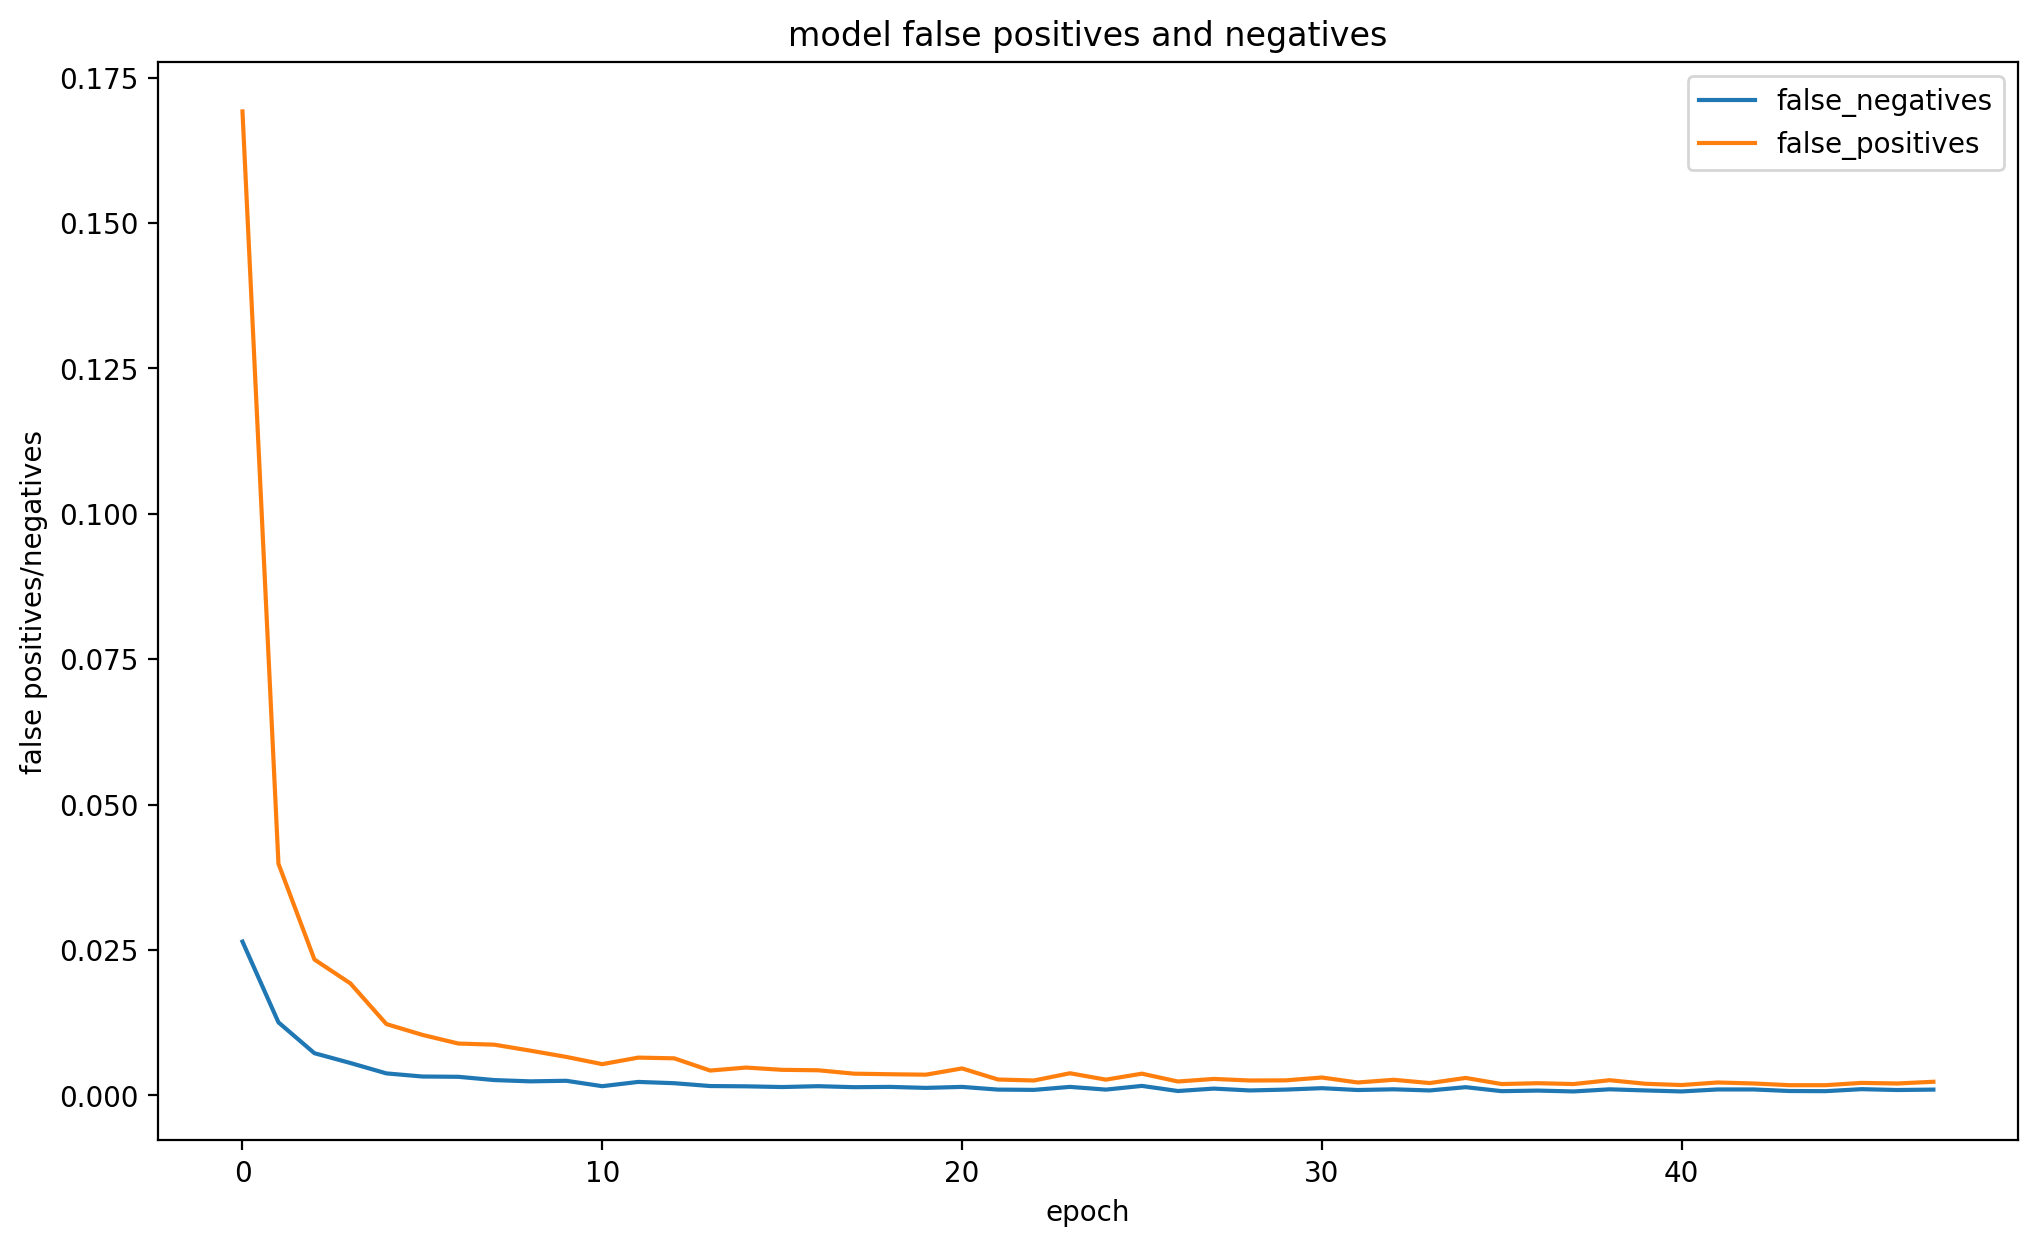

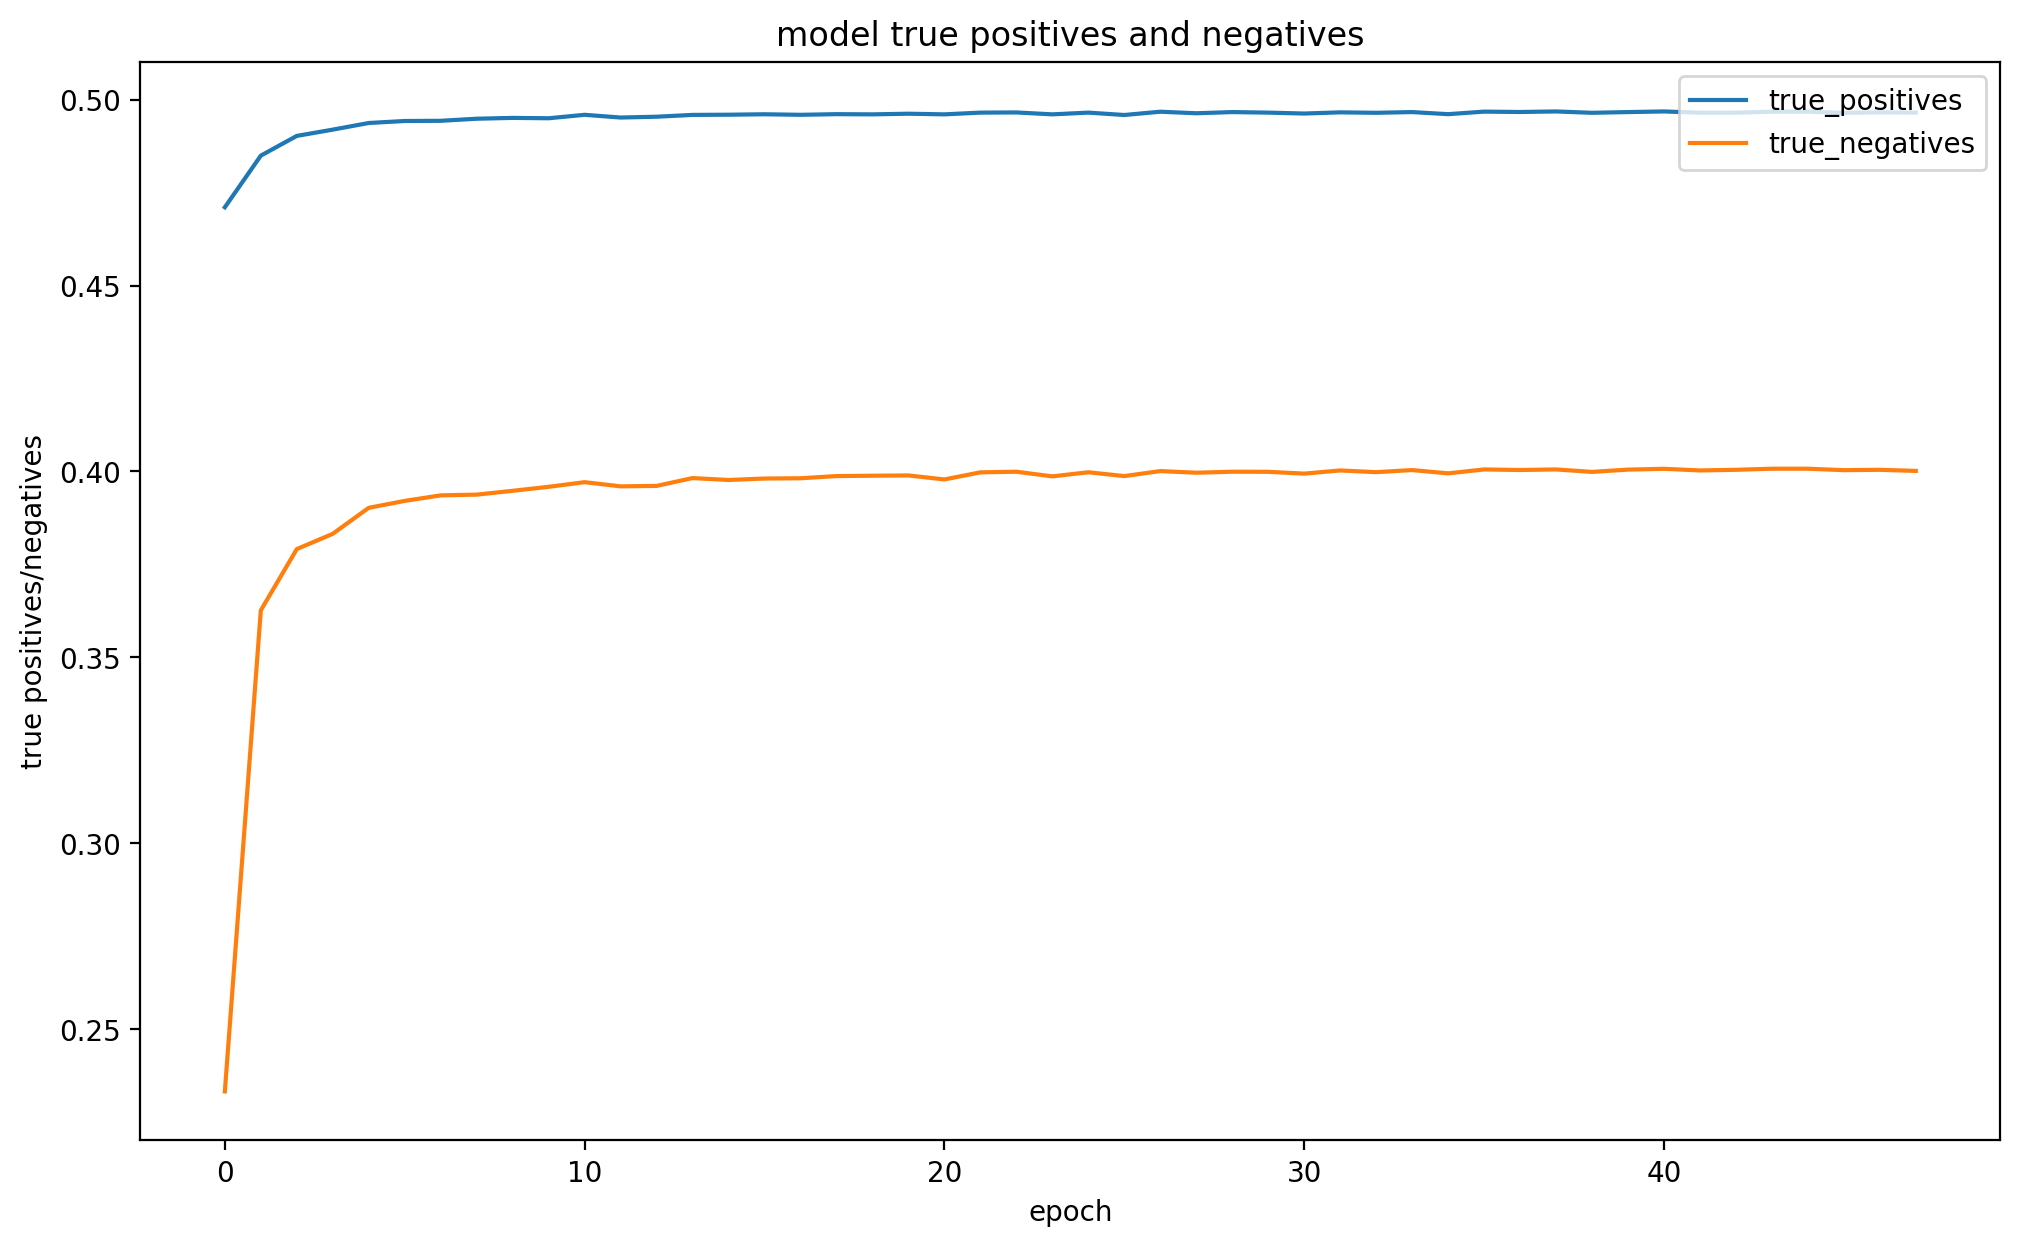

In [132]:
N = len(X_train)
plt.plot(np.array(history.history['false_negatives']) / N, label='false_negatives')
plt.plot(np.array(history.history['false_positives']) / N, label='false_positives')

#plt.plot(np.array(history.history['val_false_negatives_2']) / (N * 0.1))
plt.title('model false positives and negatives')
plt.ylabel('false positives/negatives')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

plt.plot(np.array(history.history['true_positives']) / N, label='true_positives')
plt.plot(np.array(history.history['true_negatives']) / N, label='true_negatives')
plt.title('model true positives and negatives')
plt.ylabel('true positives/negatives')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()


In [59]:
y_test.shape

(20153,)

In [60]:
model.metrics

## Feature importance

In [150]:
import lime
from lime import lime_tabular

In [152]:
col_names = df_processed.columns.tolist()
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=col_names, class_names=['e', 'p'], discretize_continuous=True)

In [155]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test[i], model.predict, num_features=2, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 0s 1ms/step


/projects/b5ac259d-f913-4317-a944-3cee4972069d/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [133]:
import eli5
from eli5.sklearn import PermutationImportance

In [146]:
eli5.show_weights(model)#, feature_names = df_processed.columns.tolist())

In [142]:
perm = PermutationImportance(model, random_state=42, scoring='recall').fit(X, y)
eli5.show_weights(perm, feature_names = df_processed.columns.tolist())

1909/1909 [==============================] - 2s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets